In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import isfile

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

import pickle

sns.set_style(style='white')
sns.set_palette(sns.color_palette("Dark2"))

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

%matplotlib inline

**Импорт данных**

In [2]:
iris = datasets.load_iris()

data_columns_names = [
    'sepal_l', 'sepal_w', 'petal_l', 'petal_w'
]

X = pd.DataFrame()
X = pd.DataFrame(iris.data, columns=data_columns_names)

y_classes = iris.target_names
y = iris.target.reshape(-1, 1)

X['class'] = y
X['class_name'] = y_classes[X['class']]

In [3]:
X.head()

,sepal_l,sepal_w,petal_l,petal_w,class,class_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [4]:
print(X.isna().sum())

sepal_l       0
sepal_w       0
petal_l       0
petal_w       0
class         0
class_name    0
dtype: int64


In [5]:
X.shape

(150, 6)

In [6]:
X.drop_duplicates(inplace=True)

Вот она, капля дёгтя - дубликат.

In [7]:
X.shape

(149, 6)

In [8]:
print("Class {}: {}. Class {}: {}. Class {}: {}.".format(
    y_classes[0], X.loc[X['class'] == 0].shape[0], 
    y_classes[1], X.loc[X['class'] == 1].shape[0], 
    y_classes[2], X.loc[X['class'] == 2].shape[0]
))

Class setosa: 50. Class versicolor: 50. Class virginica: 49.


Почти идеальные данные. Всё на месте, ничего не пропущенно. Отличная балансировка по классам.

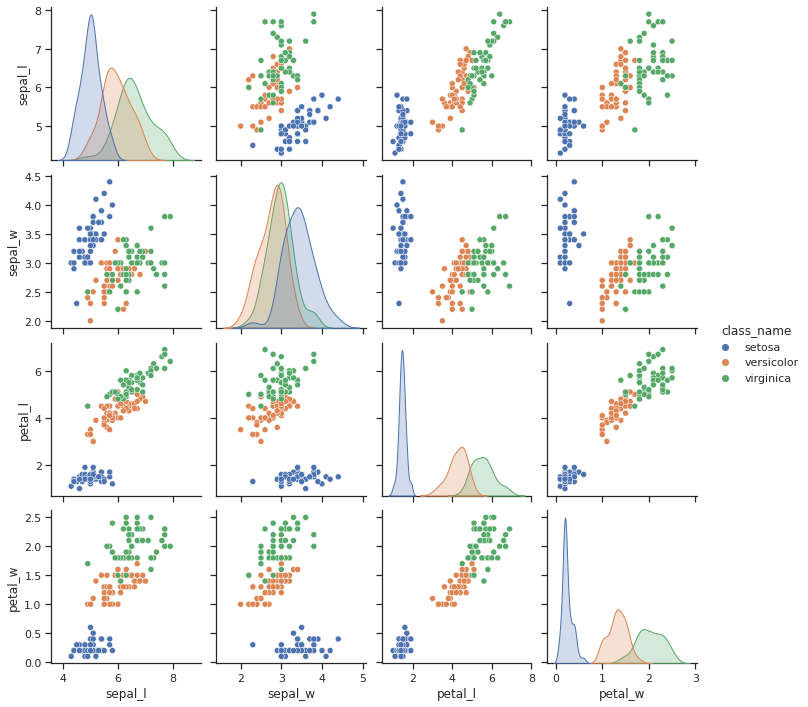

In [9]:
sns.set_theme(style="ticks")

a = sns.pairplot(data=X.loc[:, X.columns != 'class'], hue='class_name')

Проще всего будет классифицировать Setosa, поскольку он имеет кардинально иные пропорции чашелистника и размеры лепестка.

![title](img/02.svg)

<a href="https://www.kaggle.com/sunaysawant/iris-eda">Источник иллюстрации.</a>

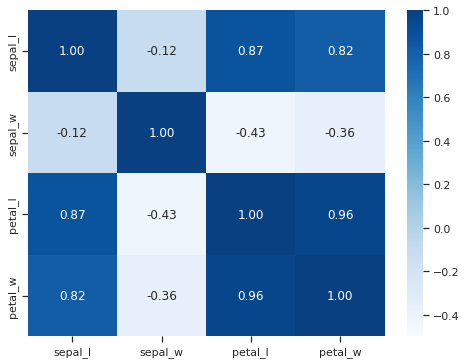

In [10]:
f, ax = plt.subplots(figsize=(8, 6))
a = sns.heatmap(data=X.loc[:, X.columns != 'class'].corr(), annot=True, fmt=".2f", cmap='Blues', vmin=-.5, vmax=1.0, center=0.3)

О! Ширина и высота лепестка связаны почти линейно. При этом, длинна лепестка так-же почти линейно связанна с длинной чашелистника. Удалю ширину лепестка и длинну чашелистника.

In [11]:
X_ = X.drop(['petal_w','sepal_l', 'class', 'class_name'] , axis=1)
X_.head()

,sepal_w,petal_l
0,3.5,1.4
1,3.0,1.4
2,3.2,1.3
3,3.1,1.5
4,3.6,1.4


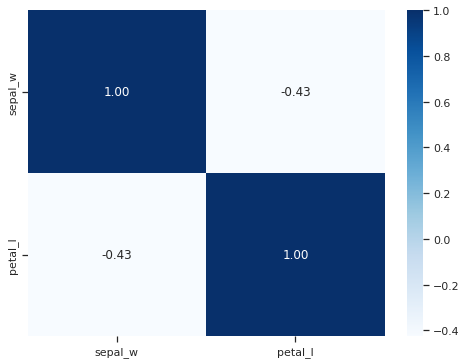

In [12]:
f, ax = plt.subplots(figsize=(8, 6))
a = sns.heatmap(data=X_.corr(), annot=True, fmt=".2f", cmap='Blues')

Эта картина мне нравится намного больше. Хотя обучу еще модель на полном датасете, чтобы оценить разницу.

**Базовая модель**

Ничего проще логистической регрессии я не знаю, с неё и начну.

Есть нюанс. Логистическая регрессия это бинарный классификатор. А классов три. Но тут есть техника One-vs-Rest. Суть понятна из названия.

In [13]:
y_ = X[['class']].to_numpy().flatten()

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_, y_, test_size=0.2, shuffle=True, stratify=y_, random_state=42)

In [14]:
lr_result_01 = None

if isfile("./data/models/model_lr_01.pkl"):
    with open("./data/models/model_lr_01.pkl", "rb") as m_file:
        lr_result_01 = pickle.load(m_file)
else:
    model_lr = LogisticRegression(multi_class='ovr')
    
    c_values = np.arange(1, 100, 1)
    l1_ratio = np.arange(0.1, 0.9, 0.1)
    
    params = [
        {'solver': ['sag'], 'penalty': ['l2'], 'C': c_values},
        {'solver': ['sag'], 'penalty': ['none']},
        {'solver': ['newton-cg'], 'penalty': ['l2'], 'C': c_values},
        {'solver': ['newton-cg'], 'penalty': ['none']},
        {'solver': ['lbfgs'], 'penalty': ['l2'], 'C': c_values},
        {'solver': ['lbfgs'], 'penalty': ['none']},
        {'solver': ['saga'], 'penalty': ['l2', 'l1'], 'C': c_values},
        {'solver': ['saga'], 'penalty': ['elasticnet'], 'C': c_values, 'l1_ratio': l1_ratio},
        {'solver': ['saga'], 'penalty': ['none']}
    ]

    cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    
    grid_search = GridSearchCV(estimator=model_lr, param_grid=params, cv=cross_val, scoring='accuracy',error_score=0)
    
    with ignore_warnings(category=ConvergenceWarning):
        lr_result_01 = grid_search.fit(X_train_1, y_train_1)
    
    with open("./data/models/model_lr_01.pkl", "wb") as m_file:
        pickle.dump(lr_result_01, m_file)

А теперь полный датасет.

In [15]:
X_ = X.drop(['class', 'class_name'] , axis=1)
X_.head()

,sepal_l,sepal_w,petal_l,petal_w
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [16]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_, y_, test_size=0.2, shuffle=True, stratify=y_, random_state=42)

In [17]:
lr_result_02 = None

if isfile("./data/models/model_lr_02.pkl"):
    with open("./data/models/model_lr_02.pkl", "rb") as m_file:
        lr_result_02 = pickle.load(m_file)
else:
    model_lr = LogisticRegression(multi_class='ovr')
    
    c_values = np.arange(1, 100, 1)
    l1_ratio = np.arange(0.1, 0.9, 0.1)
    
    params = [
        {'solver': ['sag'], 'penalty': ['l2'], 'C': c_values},
        {'solver': ['sag'], 'penalty': ['none']},
        {'solver': ['newton-cg'], 'penalty': ['l2'], 'C': c_values},
        {'solver': ['newton-cg'], 'penalty': ['none']},
        {'solver': ['lbfgs'], 'penalty': ['l2'], 'C': c_values},
        {'solver': ['lbfgs'], 'penalty': ['none']},
        {'solver': ['saga'], 'penalty': ['l2', 'l1'], 'C': c_values},
        {'solver': ['saga'], 'penalty': ['elasticnet'], 'C': c_values, 'l1_ratio': l1_ratio},
        {'solver': ['saga'], 'penalty': ['none']}
    ]

    cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    
    grid_search = GridSearchCV(estimator=model_lr, param_grid=params, cv=cross_val, scoring='accuracy',error_score=0)
    
    with ignore_warnings(category=ConvergenceWarning):
        lr_result_02 = grid_search.fit(X_train_2, y_train_2)
    
    with open("./data/models/model_lr_02.pkl", "wb") as m_file:
        pickle.dump(lr_result_02, m_file)

In [18]:
print("Accuracy scores are:\n\tDropped:\t{:.4f}\n\tFull:\t\t{:.4f}".format(lr_result_01.best_score_, lr_result_02.best_score_))
print("\nModels hyperparameters are:\n\tDropped:\t{}\n\tFull:\t\t{}".format(lr_result_01.best_params_, lr_result_02.best_params_))
print("\nModel coefficients are:\n\tDropped:\t\n{}\n\tFull\t\n{}".format(lr_result_01.best_estimator_.coef_, lr_result_02.best_estimator_.coef_))

Accuracy scores are:
	Dropped:	0.9548
	Full:		0.9662

Models hyperparameters are:
	Dropped:	{'C': 7, 'penalty': 'l2', 'solver': 'sag'}
	Full:		{'C': 1, 'penalty': 'l2', 'solver': 'saga'}

Model coefficients are:
	Dropped:	
[[ 2.62316226 -3.32598856]
 [-2.58345727  0.08791001]
 [-2.94496286  3.68214732]]
	Full	
[[ 0.31087884  1.40115451 -2.1342651  -0.9640319 ]
 [ 0.51743142 -1.77979727  0.43355414 -1.23678018]
 [-1.55122297 -1.13607105  2.34965202  2.1770071 ]]


Интересно, что гиперпараметры подобрались разные. Сама по себе точность мало о чем говорит, попробую построить ROC кривые.

In [19]:
predict_1 = lr_result_01.best_estimator_.predict_proba(X_test_1)
predict_2 = lr_result_02.best_estimator_.predict_proba(X_test_2)

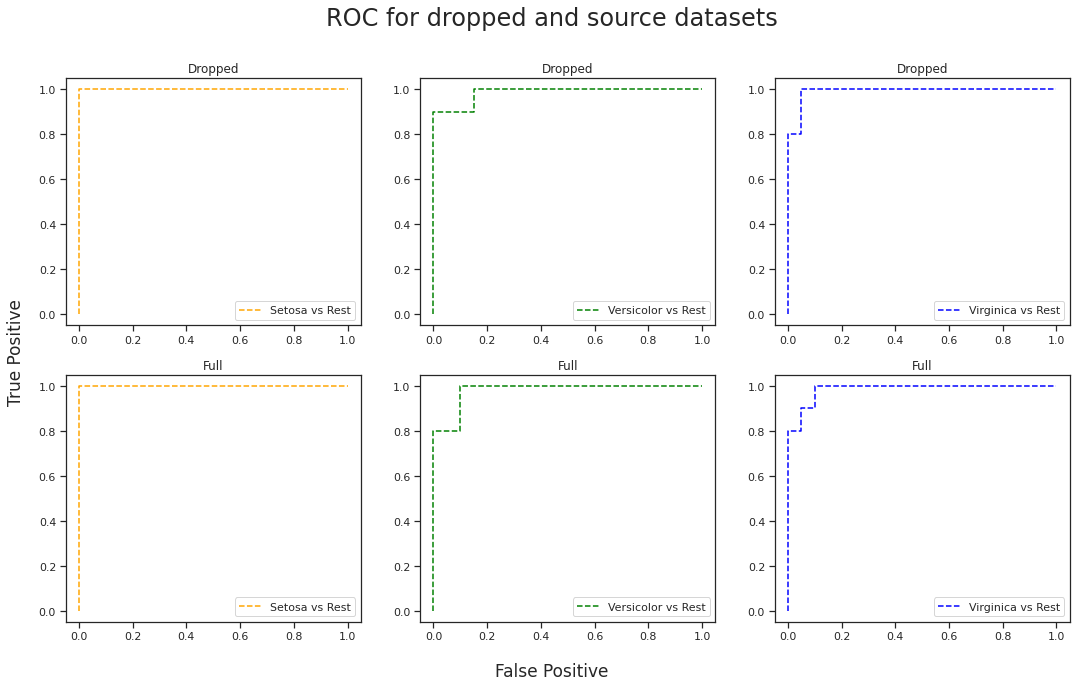

In [20]:
n_class = 3

fp_1, tp_1, thr_1 = {}, {}, {}
fp_2, tp_2, thr_2 = {}, {}, {}

for i in range(n_class):
    fp_1[i], tp_1[i], thr_1[i] = roc_curve(y_test_1, predict_1[:,i], pos_label=i)
    fp_2[i], tp_2[i], thr_2[i] = roc_curve(y_test_2, predict_2[:,i], pos_label=i)

fig, ax = plt.subplots(2, 3)
fig.set_size_inches(18, 10)
fig.suptitle('ROC for dropped and source datasets', fontsize=24)

colors = {
    0: 'orange',
    1: 'green',
    2: 'blue'
}

labels = {
    0: 'Setosa vs Rest',
    1: 'Versicolor vs Rest',
    2: 'Virginica vs Rest'
}

fig.text(0.5, 0.05, 'False Positive', ha='center', fontsize=17)
fig.text(0.08, 0.5, 'True Positive', va='center', rotation='vertical', fontsize=17)

for i in range(0, 2):
    for j in range(0, 3):
        if i == 0:
            ax[i, j].set_title('Dropped')
            ax[i, j].plot(fp_1[j], tp_1[j], linestyle='--',color=colors[j], label=labels[j])
        else:
            ax[i, j].set_title('Full')
            ax[i, j].plot(fp_2[j], tp_2[j], linestyle='--',color=colors[j], label=labels[j])
        ax[i, j].legend(loc='best')

In [21]:
print('AUC for dataframe with no collinear data:\t{:.4f}'.format(roc_auc_score(y_test_1, predict_1, multi_class='ovr')))
print('AUC for dataframe with collinear data:\t\t{:.4f}'.format(roc_auc_score(y_test_2, predict_2, multi_class='ovr')))

AUC for dataframe with no collinear data:	0.9917
AUC for dataframe with collinear data:		0.9883


С Setosa, как и предпологалось, всё очень хорошо - стабильная единичка. А вот без коллиниарных предикторов AUC для остальных классов лучше.

Важный момент. Почему я принял решение на основании AUC, а не accuracy. Accuracy это характеристика в моменте, так сказать. То есть, я оцениваю как отработал алгоритм на конкретном наборе данных с конкретным threshold. Площадь же под кривой (AUC), показывает насколько классификатор правильно оценит случайно выбранный positive (выдаст более высокую вероятность быть positive), чем случайно выбранный negaive. То есть ROC/AUC это оценка работы алгоритма в целом. <br>
По крайней мере, так я понимаю вопрос.

Попробую еще нормализовать. Точнее, я вынужден это сделать, поскольку для SVC это необходимо.

In [22]:
X_ = X.drop(['petal_w','sepal_l', 'class', 'class_name'] , axis=1)

X_scaled = StandardScaler().fit_transform(X_)

X_ = pd.DataFrame(X_scaled, columns=X_.columns)

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_, y_, test_size=0.2, shuffle=True, stratify=y_, random_state=42)

In [23]:
lr_result_03 = None

if isfile("./data/models/model_lr_03.pkl"):
    with open("./data/models/model_lr_03.pkl", "rb") as m_file:
        lr_result_03 = pickle.load(m_file)
else:
    model_lr = LogisticRegression(multi_class='ovr')
    
    c_values = np.arange(1, 100, 1)
    l1_ratio = np.arange(0.1, 0.9, 0.1)
    
    params = [
        {'solver': ['sag'], 'penalty': ['l2'], 'C': c_values},
        {'solver': ['sag'], 'penalty': ['none']},
        {'solver': ['newton-cg'], 'penalty': ['l2'], 'C': c_values},
        {'solver': ['newton-cg'], 'penalty': ['none']},
        {'solver': ['lbfgs'], 'penalty': ['l2'], 'C': c_values},
        {'solver': ['lbfgs'], 'penalty': ['none']},
        {'solver': ['saga'], 'penalty': ['l2', 'l1'], 'C': c_values},
        {'solver': ['saga'], 'penalty': ['elasticnet'], 'C': c_values, 'l1_ratio': l1_ratio},
        {'solver': ['saga'], 'penalty': ['none']}
    ]

    cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    
    grid_search = GridSearchCV(estimator=model_lr, param_grid=params, cv=cross_val, scoring='accuracy',error_score=0)
    
    with ignore_warnings(category=ConvergenceWarning):
        lr_result_03 = grid_search.fit(X_train_3, y_train_3)
    
    with open("./data/models/model_lr_03.pkl", "wb") as m_file:
        pickle.dump(lr_result_03, m_file)

In [24]:
fp_3, tp_3, thr_3 = {}, {}, {}

predict_3 = lr_result_03.best_estimator_.predict_proba(X_test_3)

for i in range(n_class):
    fp_3[i], tp_3[i], thr_3[i] = roc_curve(y_test_3, predict_3[:,i], pos_label=i)

print('AUC for normalized dataframe :\t{:.4f}'.format(roc_auc_score(y_test_3, predict_3, multi_class='ovr')))
print("\nModels hyperparameters are: {}".format(lr_result_03.best_params_))

AUC for normalized dataframe :	0.9883

Models hyperparameters are: {'C': 78, 'penalty': 'l2', 'solver': 'newton-cg'}


Хм, поменялось и ядро и параметры. И точность точно как у коллениарных данных.

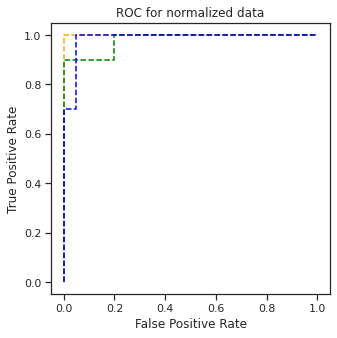

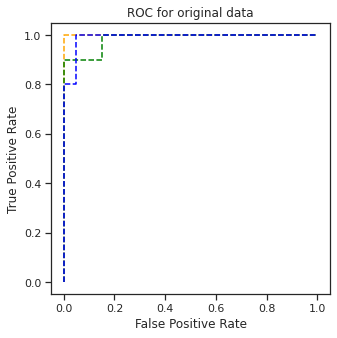

In [25]:
plt.subplots(1, figsize=(5, 5))
plt.title('ROC for normalized data')
plt.plot(fp_3[0], tp_3[0], linestyle='--',color=colors[0], label=labels[0])
plt.plot(fp_3[1], tp_3[1], linestyle='--',color=colors[1], label=labels[1])
plt.plot(fp_3[2], tp_3[2], linestyle='--',color=colors[2], label=labels[2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.subplots(1, figsize=(5, 5))
plt.title('ROC for original data')
plt.plot(fp_1[0], tp_1[0], linestyle='--',color=colors[0], label=labels[0])
plt.plot(fp_1[1], tp_1[1], linestyle='--',color=colors[1], label=labels[1])
plt.plot(fp_1[2], tp_1[2], linestyle='--',color=colors[2], label=labels[2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

AUC один и тот-же, а кривые немного разные.

**Support Vector Machine (SVM)**

In [26]:
svm_result = None

if isfile("./data/models/model_svm.pkl"):
    with open("./data/models/model_svm.pkl", "rb") as m_file:
        svm_result = pickle.load(m_file)
else:
    model_svm = SVC(decision_function_shape='ovr')#, probability=True)
    
    c_values = np.arange(1, 100, 1)
    gamma_p = ['scale', 'auto']
    degree_p = np.arange(1, 10, 1)
    coef0_p = np.arange(0, 1, 0.1)
    
    params = [
        {'kernel': ['linear'], 'C': c_values},
        {'kernel': ['poly'], 'C': c_values, 'degree': degree_p, 'gamma': gamma_p, 'coef0': coef0_p},
        {'kernel': ['rbf'], 'C': c_values, 'gamma': gamma_p},
        {'kernel': ['sigmoid'], 'C': c_values, 'gamma': gamma_p, 'coef0': coef0_p}
    ]

    cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    grid_search = GridSearchCV(estimator=model_svm, param_grid=params, n_jobs=-1, cv=cross_val, scoring='accuracy',error_score=0)
    svm_result = grid_search.fit(X_train_3, y_train_3)
    
    with open("./data/models/model_svm.pkl", "wb") as m_file:
        pickle.dump(svm_result, m_file)

In [27]:
fp_svc, tp_svc, thr_svc = {}, {}, {}

predict_svc = svm_result.best_estimator_.predict_proba(X_test_3)

for i in range(n_class):
    fp_svc[i], tp_svc[i], thr_svc[i] = roc_curve(y_test_3, predict_svc[:,i], pos_label=i)

print('AUC for SVC :\t{:.4f}'.format(roc_auc_score(y_test_3, predict_svc, multi_class='ovr')))
print("\nModels hyperparameters are: {}".format(svm_result.best_params_))

AUC for SVC :	0.9933

Models hyperparameters are: {'C': 3, 'kernel': 'linear'}


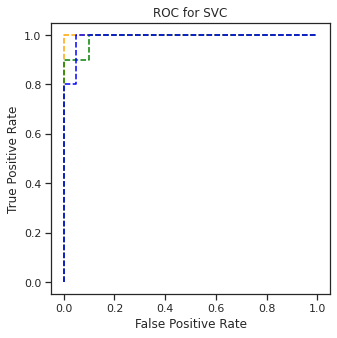

In [28]:
plt.subplots(1, figsize=(5, 5))
plt.title('ROC for SVC')
plt.plot(fp_svc[0], tp_svc[0], linestyle='--',color=colors[0], label=labels[0])
plt.plot(fp_svc[1], tp_svc[1], linestyle='--',color=colors[1], label=labels[1])
plt.plot(fp_svc[2], tp_svc[2], linestyle='--',color=colors[2], label=labels[2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

Как сделать ещё лучше, я себе просто не представляю)

И в конце, можно попробовать, что получается на полном наборе данных.

In [29]:
predict_svc = svm_result.best_estimator_.predict_proba(X_)
predict_lr = lr_result_03.best_estimator_.predict_proba(X_)

In [30]:
print('AUC for SVC :\t{:.4f}'.format(roc_auc_score(y_, predict_svc, multi_class='ovr')))
print('AUC for LR :\t{:.4f}'.format(roc_auc_score(y_, predict_lr, multi_class='ovr')))

AUC for SVC :	0.9946
AUC for LR :	0.9916


**Некоторые пояснения**

Копи-паст это, конечно, плохо. Но Jupyter не предлагает (я точно таких не знаю) инструментов для быстрого перехода к объявлениям. Поэтому накопипастил.<br>
Confusion matrix не строил, поскольку в этой задаче не вижу в ней смысла.

**Заключение**

Гиперпараметры это важно. На одних и тех-же, казалось-бы, данных получаются разные по сути модели. Подбирать их вручную малореально. Разве что для самых базовых оценок.

Не могу судить на предоставленных данных, какая модель лучше - логистическая регрессия или опорные вектора. Обе модели выдали близкие к идеальным результаты. Но для логистической регрессии точно быстрее подбирать гиперпараметры. Хотя три тысячных тоже на дороге не валяются! :-)